In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from triagerx.dataset.processor import DatasetProcessor
from triagerx.model.roberta_cnn import RobertaCNNClassifier
from triagerx.model.roberta_fcn import RobertaFCNClassifier
# from triagerx.model.lbt_p import LBTPClassifier
from triagerx.trainer.model_trainer import ModelTrainer
from triagerx.trainer.train_config import TrainConfig

# Load Data

In [2]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/merged_data_dated.csv"

In [3]:
sample_threshold = 5

df = DatasetProcessor.process_dataset(dataset_path, sample_threshold=sample_threshold)

2024-01-28 17:03:37.473 | DEBUG    | triagerx.dataset.processor:load_dataframe:8 - Loading dataframe: /home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/merged_data_dated.csv
2024-01-28 17:03:38.386 | DEBUG    | triagerx.dataset.processor:prepare_dataframe:24 - Filtering developers based on minimum contribution: 5...
2024-01-28 17:03:38.392 | DEBUG    | triagerx.dataset.processor:prepare_dataframe:32 - Generating 'text' field...
2024-01-28 17:03:38.445 | DEBUG    | triagerx.dataset.processor:prepare_dataframe:44 - Dropping rows with 'text' length < 15...
2024-01-28 17:03:38.453 | DEBUG    | triagerx.dataset.processor:clean_data:13 - Cleaning dataset...


In [4]:
len(df["assignees"].unique())

50

<Axes: xlabel='assignees'>

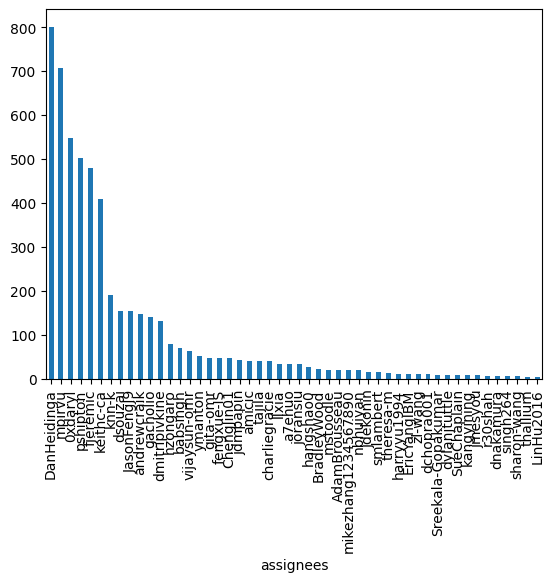

In [5]:
df["assignees"].value_counts().plot(kind="bar")

In [6]:
np.random.seed(42)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["owner_id"])
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df["owner_id"])

In [7]:
assert len(train_df.owner_id.unique()) == len(train_df.owner_id.unique()) == len(valid_df.owner_id.unique())

# Training

In [8]:
model2 = RobertaCNNClassifier(
    model_name="roberta-large",
    output_size=len(train_df.owner_id.unique()),
    embed_size=1024
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import torch

In [10]:
import torch
import torch.nn.functional as F
from torch import nn
from transformers import RobertaModel, RobertaTokenizer


class LBTPClassifier(nn.Module):
    def __init__(
        self, output_size, bert_unfreeze_layers=4, embed_size=1024, dropout=0.1
    ) -> None:
        super().__init__()
        model_name = "roberta-large"
        self.base_model = RobertaModel.from_pretrained(
            model_name, output_hidden_states=True
        )
        self._tokenizer = RobertaTokenizer.from_pretrained(model_name)

        # Freeze embedding layers
        for p in self.base_model.embeddings.parameters():
            p.requires_grad = False

        # Freeze encoder layers till defined unfreeze layers
        for i in range (0, 24 - bert_unfreeze_layers):
            for p in self.base_model.encoder.layer[i].parameters():
                p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = 256
        self._max_tokens = 512
        self._embed_size = embed_size
        self._bert_unfreeze_layers = bert_unfreeze_layers
        self.conv_blocks = nn.ModuleList(
            [nn.ModuleList(
            [nn.Sequential(
                nn.Conv2d(1, self._num_filters, (K, embed_size)),
                nn.ReLU(),
                nn.Flatten(),
                nn.MaxPool1d(self._max_tokens - (K - 1)),
                nn.Flatten(start_dim=1)
            )
            for K in filter_sizes])
            for _ in range(bert_unfreeze_layers)]
        ) 

        self.classifiers = nn.ModuleList([
            nn.Linear(len(filter_sizes) * self._num_filters + embed_size, output_size)
            for _ in range(bert_unfreeze_layers)
        ])

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        outputs = []

        base_out = self.base_model(input_ids, attention_mask=attention_mask)
        pooler_out = base_out.pooler_output.squeeze(0)
        hidden_states = base_out.hidden_states[-self._bert_unfreeze_layers:]

        for i in range(self._bert_unfreeze_layers):
          batch_size, sequence_length, hidden_size = hidden_states[i].size()
          x = [conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size)) for conv in self.conv_blocks[i]]          
          x = torch.cat(x, dim=1)   
          x = torch.cat([pooler_out, x], dim=1)    
          x = self.dropout(x)
          x = self.classifiers[i](x)
          
          outputs.append(x)

        return outputs

    def tokenizer(self) -> RobertaTokenizer:
        return self._tokenizer

In [11]:
class CombineLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self._ce = nn.CrossEntropyLoss()

    def forward(
        self,
        prediction,
        labels
    ) -> torch.Tensor:
        loss = 0

        for i in range(len(prediction)):
            loss += self._ce(prediction[i], labels)
            # print(loss)

        return loss

In [12]:
model = LBTPClassifier(
    output_size=len(train_df.owner_id.unique())
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
class_counts = np.bincount(train_df["owner_id"])
num_samples = sum(class_counts)
labels = train_df["owner_id"].to_list() #corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [14]:
learning_rate = 1e-5
epochs = 50
batch_size = 15

# Create sampler
# counts = np.bincount(train_df["owner_id"])
# labels_weights = 1. / counts
# weights = labels_weights[train_df["owner_id"]]
# sampler = WeightedRandomSampler(weights, len(weights))

sampler_name = sampler.__class__.__name__ if sampler else "None"
model_name = model.__class__.__name__

output_file = f"{model_name}_{sample_threshold}_frozen_labels_{sampler_name}"
output_path = f"/home/mdafifal.mamun/notebooks/triagerX/output/{output_file}.pt"

wandb_config = {
        "project": "triagerx",
        "name": f"run_{output_file}",
        "config": {
        "learning_rate": learning_rate,
        "architecture": "Roberta-CNN",
        "dataset": "openj9",
        "epochs": epochs,
    }
}

criterion = CombineLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=5, factor=0.1, threshold=1e-8)

train_config = TrainConfig(
    optimizer=optimizer,
    criterion=criterion,
    train_dataset=train_df,
    validation_dataset=valid_df,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    output_file=output_path,
    sampler=sampler,
    scheduler=scheduler,
    wandb=None
)

trainer = ModelTrainer(train_config)
trainer.train(model=model)

2024-01-28 17:03:43.628 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-28 17:03:43.630 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...
2024-01-28 17:03:50.108 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-28 17:03:50.110 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...
2024-01-28 17:03:52.114 | DEBUG    | triagerx.trainer.model_trainer:train:49 - Selected compute device: cuda
  0%|          | 0/243 [00:00<?, ?it/s]/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 243/243 [02:14<00:00,  1.80it/s]
/home/mdafifal.mamun/miniconda3/envs/tr

# Evaluation

In [ ]:
a = torch.rand(2, 2, 2)
a.shape

torch.Size([2, 2, 2])

In [ ]:
a.unsqueeze(2)

tensor([[[[0.6966, 0.9897]],

         [[0.4495, 0.7206]]],


        [[[0.5910, 0.6166]],

         [[0.2880, 0.6740]]]])

In [ ]:
a

tensor([[[0.6966, 0.9897],
         [0.4495, 0.7206]],

        [[0.5910, 0.6166],
         [0.2880, 0.6740]]])

In [ ]:
import torch
from triagerx.evaluation.evaluator import Evaluator

In [ ]:
model = RobertaCNNClassifier(
    model_name="roberta-base",
    output_size=len(train_df.owner_id.unique()),
    embed_size=768
)
model.load_state_dict(torch.load("/home/mdafifal.mamun/notebooks/triagerX/output/RobertaCNNClassifier_5_stratify_comp-labels_WeightedRandomSampler.pt"))

evaluator = Evaluator()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader
from triagerx.dataset.triage_dataset import TriageDataset

dataset = TriageDataset(test_df, model.tokenizer())

2024-01-19 08:02:14.302 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-19 08:02:14.304 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...


In [ ]:
loader = DataLoader(dataset, 30)

In [ ]:
test_df.head(30)

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,created_at,closed_at,text,owner_id
13686,56,13687,https://github.com/eclipse-openj9/openj9/pull/...,AArch64: Change symbol/function declarations i...,This commit changes the symbol and function de...,closed,knn-k,<comment><user>knn-k</user><body>jenkins compi...,0xdaryl,"comp:jit, arch:aarch64",2021-10-13T03:38:37Z,2021-10-13T11:43:29Z,Title: AArch64: Change symbol/function declara...,1
17217,25,17220,https://github.com/eclipse-openj9/openj9/pull/...,Recognize new Class methods for Valhalla proto...,This change adds support to `constrainRecogniz...,closed,hzongaro,<comment><user>hzongaro</user><body>Daryl @0xd...,0xdaryl,"comp:jit, perf, project:valhalla",2023-04-18T20:38:30Z,2023-06-15T12:20:08Z,Title: Recognize new Class methods for Valhall...,1
4707,35,4712,https://github.com/eclipse-openj9/openj9/pull/...,Clean up of Concurrent Scavenge code on Power,Comment regarding compatibility of TM and conc...,closed,IBMJimmyk,<comment><user>IBMJimmyk</user><body>Travis CI...,gita-omr,"comp:jit, arch:power",2019-02-12T20:53:51Z,2019-02-25T18:18:26Z,Title: Clean up of Concurrent Scavenge code on...,16
7828,14,7833,https://github.com/eclipse-openj9/openj9/issue...,Compilation errors with strncpy when compiling...,The compilation warning `stringop-truncation` ...,closed,ChengJin01,<comment><user>DanHeidinga</user><body>@ChengJ...,keithc-ca,NaN,2019-11-21T21:09:53Z,2020-05-11T15:32:31Z,Title: Compilation errors with strncpy when co...,6
9941,2,9945,https://github.com/eclipse-openj9/openj9/pull/...,Fix warnings building on osx,* Use explicit boolean conditions and addition...,closed,DanHeidinga,<comment><user>pshipton</user><body>@andrewcra...,andrewcraik,comp:jit,2020-06-19T04:00:22Z,2020-06-23T13:09:16Z,Title: Fix warnings building on osx\nLabels: c...,7
7580,62,7586,https://github.com/eclipse-openj9/openj9/pull/...,Avoid load rewrites for cold escapes of immuta...,Ordinarily Escape Analysis avoids fix-up of fi...,closed,hzongaro,<comment><user>hzongaro</user><body>This chang...,andrewcraik,"bug, comp:jit",2019-10-24T17:43:02Z,2019-10-25T18:45:01Z,Title: Avoid load rewrites for cold escapes of...,7
11005,37,11006,https://github.com/eclipse-openj9/openj9/pull/...,AArch64: Revert the change for LinkageInfo wor...,This commit reverts the AArch64 part of the ch...,closed,knn-k,<comment><user>knn-k</user><body>jenkins test ...,0xdaryl,"comp:jit, arch:aarch64",2020-10-27T05:42:30Z,2020-10-27T11:36:42Z,Title: AArch64: Revert the change for LinkageI...,1
9152,90,9157,https://github.com/eclipse-openj9/openj9/pull/...,CMake: Modify arch tuning value for jit on aix,Signed-off-by: Devin Nakamura <devinn@ca.ibm.com>,closed,dnakamura,<comment><user>dnakamura</user><body>@pshipton...,pshipton,comp:build,2020-04-07T14:11:59Z,2020-07-27T17:19:32Z,Title: CMake: Modify arch tuning value for jit...,15
10204,38,10205,https://github.com/eclipse-openj9/openj9/pull/...,Add JIT Hooks Documentation,NaN,closed,dsouzai,<comment><user>mpirvu</user><body>@dsouzai Do ...,mpirvu,"comp:jit, comp:doc",2020-07-21T14:43:15Z,2020-07-28T17:35:34Z,Title: Add JIT Hooks Documentation\nLabels: co...,5
3486,56,3489,https://github.com/eclipse-openj9/openj9/pull/...,Changes to get ddrgen working on OSX,These are the changes required on the OpenJ9 s...,closed,mikezhang1234567890,<comment><user>keithc-ca</user><body>Jenkins t...,keithc-ca,comp:vm,2018-10-30T20:59:05Z,2018-11-06T17:39:37Z,Title: Changes to get ddrgen working on OSX\nL...,6


In [ ]:
device = "cuda"
all_preds = []
all_labels = []

model = model.cuda()

with torch.no_grad():

    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input["attention_mask"].to(device)
        input_id = val_input["input_ids"].squeeze(1).to(device)

        output = model(input_id, mask)
        output = nn.Softmax(dim=1)(output)
        conf, classes = output.topk(10, dim=1)

        print("Pred", output.argmax(dim=1))
        print("Label", val_label.long())
        print("Top 3", classes)

        # batch_loss = criterion(output, val_label.long())
        # total_loss_val += batch_loss.item()

        # acc = (output.argmax(dim=1) == val_label).sum().item()
        
        # all_preds.append(output.cpu().numpy())
        # all_labels.append(val_label.cpu().numpy())
        
        # total_acc_val += acc

        break

Pred tensor([ 1, 37, 16,  6,  7,  7,  1, 15,  4,  2,  5,  8,  2,  1, 29, 19,  5,  1,
        17,  2, 17, 12,  1, 19, 15,  2, 21, 12,  5,  4], device='cuda:0')
Label tensor([ 1,  1, 16,  6,  7,  7,  1, 15,  5,  6,  5,  1, 31,  7,  6, 19,  5,  1,
        17,  6,  6, 12,  1, 21, 15,  2, 21, 10,  5,  7], device='cuda:0')
Top 3 tensor([[ 1,  7, 31, 15,  4,  6,  2, 11, 19, 16],
        [37, 11,  7,  1, 27, 36,  5, 19, 31, 34],
        [16,  1,  4, 15,  5,  2,  7,  6, 37, 12],
        [ 6, 17, 29, 33, 15, 11,  2, 37, 40, 39],
        [ 7,  1,  4, 11, 15, 16,  2, 19, 31,  0],
        [ 7, 11,  1, 16, 24, 19,  4, 37, 10, 17],
        [ 1, 15, 31,  7,  6,  4,  2, 19,  5, 16],
        [15,  2,  6,  4,  1,  5,  0, 17,  3, 31],
        [ 4, 19,  1,  5, 14, 31, 16, 24,  7, 37],
        [ 2,  6, 15, 39, 17,  4,  0, 12, 29,  1],
        [ 5, 19, 21,  4, 37, 24,  7,  1, 25, 16],
        [ 8,  1, 19,  4,  7, 11, 16,  0,  5, 15],
        [ 2, 15, 17,  6, 29, 39, 34, 30,  5, 22],
        [ 1,  4,  7, 16, 

In [ ]:
from triagerx.dataset.triage_dataset import TriageDataset

In [ ]:
import pandas as pd

In [ ]:
x_df = df.copy()

In [ ]:
x_df.head()

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,created_at,closed_at,text,owner_id
9,33,10,https://github.com/eclipse-openj9/openj9/pull/10,Update README.md with proper AdoptOpenJDK link,"Also remove the the coming soon reference, sin...",closed,pshipton,NaN,charliegracie,comp:doc,2017-09-14T12:24:25Z,2017-09-14T12:42:15Z,Title: Update README.md with proper AdoptOpenJ...,0
14,28,15,https://github.com/eclipse-openj9/openj9/pull/15,Refactor and clean up CodeCacheManager,- Change invocation parameters of superclass c...,closed,lmaisons,<comment><user>lmaisons</user><body>This has a...,0xdaryl,comp:jit,2017-09-14T14:30:51Z,2017-09-27T20:01:54Z,Title: Refactor and clean up CodeCacheManager\...,1
16,26,17,https://github.com/eclipse-openj9/openj9/pull/17,WIP Add support for function pointers in Panama,When invoking a native function (with Panama) ...,closed,tajila,<comment><user>tajila</user><body>Thanks for t...,DanHeidinga,"comp:vm, project:panama",2017-09-14T16:10:32Z,2019-12-04T15:50:33Z,Title: WIP Add support for function pointers i...,2
21,21,22,https://github.com/eclipse-openj9/openj9/pull/22,fix illegal-access behaviour,fix illegal-access behaviour\r\n\r\nThis is th...,closed,tajila,<comment><user>DanHeidinga</user><body>@tajila...,DanHeidinga,"jdk9, comp:vm",2017-09-14T20:53:59Z,2017-09-15T14:23:40Z,Title: fix illegal-access behaviour\nLabels: j...,2
23,19,24,https://github.com/eclipse-openj9/openj9/issue...,Enable a travis.ci-based PR build for linux x8...,Build a basic PR build based off the linux_x86...,closed,DanHeidinga,<comment><user>mgaudet</user><body>This has be...,DanHeidinga,comp:build,2017-09-15T04:24:17Z,2017-11-09T14:15:08Z,Title: Enable a travis.ci-based PR build for l...,2


In [ ]:
x_df["assignee_w_id"] = x_df.apply(lambda x: str(x["assignees"]) + " " + str(x["owner_id"]), axis=1)

In [ ]:
x_df.head()

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,created_at,closed_at,text,owner_id,assignee_w_id
9,33,10,https://github.com/eclipse-openj9/openj9/pull/10,Update README.md with proper AdoptOpenJDK link,"Also remove the the coming soon reference, sin...",closed,pshipton,NaN,charliegracie,comp:doc,2017-09-14T12:24:25Z,2017-09-14T12:42:15Z,Title: Update README.md with proper AdoptOpenJ...,0,charliegracie 0
14,28,15,https://github.com/eclipse-openj9/openj9/pull/15,Refactor and clean up CodeCacheManager,- Change invocation parameters of superclass c...,closed,lmaisons,<comment><user>lmaisons</user><body>This has a...,0xdaryl,comp:jit,2017-09-14T14:30:51Z,2017-09-27T20:01:54Z,Title: Refactor and clean up CodeCacheManager\...,1,0xdaryl 1
16,26,17,https://github.com/eclipse-openj9/openj9/pull/17,WIP Add support for function pointers in Panama,When invoking a native function (with Panama) ...,closed,tajila,<comment><user>tajila</user><body>Thanks for t...,DanHeidinga,"comp:vm, project:panama",2017-09-14T16:10:32Z,2019-12-04T15:50:33Z,Title: WIP Add support for function pointers i...,2,DanHeidinga 2
21,21,22,https://github.com/eclipse-openj9/openj9/pull/22,fix illegal-access behaviour,fix illegal-access behaviour\r\n\r\nThis is th...,closed,tajila,<comment><user>DanHeidinga</user><body>@tajila...,DanHeidinga,"jdk9, comp:vm",2017-09-14T20:53:59Z,2017-09-15T14:23:40Z,Title: fix illegal-access behaviour\nLabels: j...,2,DanHeidinga 2
23,19,24,https://github.com/eclipse-openj9/openj9/issue...,Enable a travis.ci-based PR build for linux x8...,Build a basic PR build based off the linux_x86...,closed,DanHeidinga,<comment><user>mgaudet</user><body>This has be...,DanHeidinga,comp:build,2017-09-15T04:24:17Z,2017-11-09T14:15:08Z,Title: Enable a travis.ci-based PR build for l...,2,DanHeidinga 2


<Axes: xlabel='assignee_w_id'>

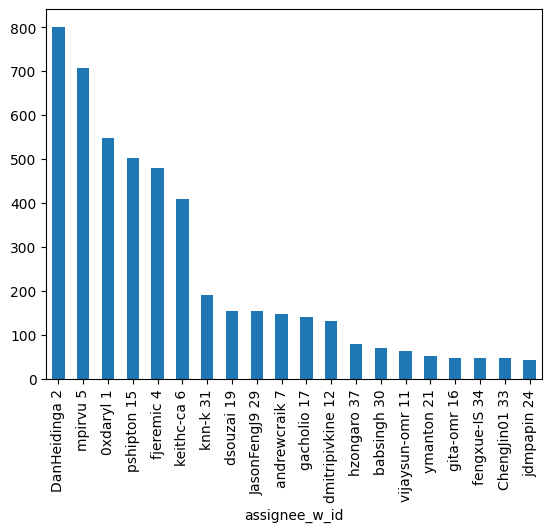

In [ ]:
x_df["assignee_w_id"].value_counts()[:20].plot(kind="bar")

In [ ]:
def predict(data, model):
    device = "cuda"
    model = model.cuda()

    with torch.no_grad():
        for val_input, val_label in loader:
            val_label = val_label.to(device)
            mask = val_input["attention_mask"].to(device)
            input_id = val_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)
            output = nn.Softmax(dim=1)(output)
            # conf, classes = output.topk(3, dim=1)

            return output.argmax(dim=1)

2024-01-18 18:40:37.707 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-18 18:40:37.709 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...


In [ ]:
test_df.head(30)

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,created_at,closed_at,text,owner_id
13686,56,13687,https://github.com/eclipse-openj9/openj9/pull/...,AArch64: Change symbol/function declarations i...,This commit changes the symbol and function de...,closed,knn-k,<comment><user>knn-k</user><body>jenkins compi...,0xdaryl,"comp:jit, arch:aarch64",2021-10-13T03:38:37Z,2021-10-13T11:43:29Z,Title: AArch64: Change symbol/function declara...,1
17217,25,17220,https://github.com/eclipse-openj9/openj9/pull/...,Recognize new Class methods for Valhalla proto...,This change adds support to `constrainRecogniz...,closed,hzongaro,<comment><user>hzongaro</user><body>Daryl @0xd...,0xdaryl,"comp:jit, perf, project:valhalla",2023-04-18T20:38:30Z,2023-06-15T12:20:08Z,Title: Recognize new Class methods for Valhall...,1
4707,35,4712,https://github.com/eclipse-openj9/openj9/pull/...,Clean up of Concurrent Scavenge code on Power,Comment regarding compatibility of TM and conc...,closed,IBMJimmyk,<comment><user>IBMJimmyk</user><body>Travis CI...,gita-omr,"comp:jit, arch:power",2019-02-12T20:53:51Z,2019-02-25T18:18:26Z,Title: Clean up of Concurrent Scavenge code on...,16
7828,14,7833,https://github.com/eclipse-openj9/openj9/issue...,Compilation errors with strncpy when compiling...,The compilation warning `stringop-truncation` ...,closed,ChengJin01,<comment><user>DanHeidinga</user><body>@ChengJ...,keithc-ca,NaN,2019-11-21T21:09:53Z,2020-05-11T15:32:31Z,Title: Compilation errors with strncpy when co...,6
9941,2,9945,https://github.com/eclipse-openj9/openj9/pull/...,Fix warnings building on osx,* Use explicit boolean conditions and addition...,closed,DanHeidinga,<comment><user>pshipton</user><body>@andrewcra...,andrewcraik,comp:jit,2020-06-19T04:00:22Z,2020-06-23T13:09:16Z,Title: Fix warnings building on osx\nLabels: c...,7
7580,62,7586,https://github.com/eclipse-openj9/openj9/pull/...,Avoid load rewrites for cold escapes of immuta...,Ordinarily Escape Analysis avoids fix-up of fi...,closed,hzongaro,<comment><user>hzongaro</user><body>This chang...,andrewcraik,"bug, comp:jit",2019-10-24T17:43:02Z,2019-10-25T18:45:01Z,Title: Avoid load rewrites for cold escapes of...,7
11005,37,11006,https://github.com/eclipse-openj9/openj9/pull/...,AArch64: Revert the change for LinkageInfo wor...,This commit reverts the AArch64 part of the ch...,closed,knn-k,<comment><user>knn-k</user><body>jenkins test ...,0xdaryl,"comp:jit, arch:aarch64",2020-10-27T05:42:30Z,2020-10-27T11:36:42Z,Title: AArch64: Revert the change for LinkageI...,1
9152,90,9157,https://github.com/eclipse-openj9/openj9/pull/...,CMake: Modify arch tuning value for jit on aix,Signed-off-by: Devin Nakamura <devinn@ca.ibm.com>,closed,dnakamura,<comment><user>dnakamura</user><body>@pshipton...,pshipton,comp:build,2020-04-07T14:11:59Z,2020-07-27T17:19:32Z,Title: CMake: Modify arch tuning value for jit...,15
10204,38,10205,https://github.com/eclipse-openj9/openj9/pull/...,Add JIT Hooks Documentation,NaN,closed,dsouzai,<comment><user>mpirvu</user><body>@dsouzai Do ...,mpirvu,"comp:jit, comp:doc",2020-07-21T14:43:15Z,2020-07-28T17:35:34Z,Title: Add JIT Hooks Documentation\nLabels: co...,5
3486,56,3489,https://github.com/eclipse-openj9/openj9/pull/...,Changes to get ddrgen working on OSX,These are the changes required on the OpenJ9 s...,closed,mikezhang1234567890,<comment><user>keithc-ca</user><body>Jenkins t...,keithc-ca,comp:vm,2018-10-30T20:59:05Z,2018-11-06T17:39:37Z,Title: Changes to get ddrgen working on OSX\nL...,6


In [ ]:
test_df[25:26]

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,created_at,closed_at,text,owner_id
3600,42,3605,https://github.com/eclipse-openj9/openj9/pull/...,Eliminate redundant bytecode size table,Information in JavaBytecodeRelocation is avail...,closed,gacholio,<comment><user>gacholio</user><body>jenkins te...,DanHeidinga,comp:vm,2018-11-07T22:48:27Z,2018-11-12T14:54:11Z,Title: Eliminate redundant bytecode size table...,2


In [ ]:
dx = test_df[25:26]
print(dx["assignees"])

dataset = TriageDataset(dx, model.tokenizer())

predict(dataset, model)

2024-01-18 18:45:30.173 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-18 18:45:30.175 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...


3600    DanHeidinga
Name: assignees, dtype: object


tensor([1], device='cuda:0')

In [ ]:
# all_preds[0]

In [ ]:
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

In [ ]:
# set(all_labels)

In [ ]:
all_preds[0]

array([ 1, 31,  7])

In [ ]:
sum(all_preds == all_labels)

ValueError: operands could not be broadcast together with shapes (802,3) (802,) 

In [ ]:
# set(all_labels) - set(all_preds)

{0, 3, 13, 18, 20, 22, 23, 25, 28, 32, 35, 38, 41, 45, 46, 47, 48}

In [ ]:
# Top 3 Predictions
evaluator.calculate_top_k_accuray(model, k=3, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

2024-01-18 18:06:22.600 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:22 - Calculating predications...
2024-01-18 18:06:35.774 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:52 - Calculating top 3 score...
2024-01-18 18:06:35.779 | INFO     | triagerx.evaluation.evaluator:calculate_top_k_accuray:55 - Top 3 score: 0.7880299251870324


0.7880299251870324

In [ ]:
# Top 5 Predictions
evaluator.calculate_top_k_accuray(model, k=5, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

2024-01-18 18:06:38.457 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:22 - Calculating predications...
2024-01-18 18:06:51.644 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:52 - Calculating top 5 score...
2024-01-18 18:06:51.648 | INFO     | triagerx.evaluation.evaluator:calculate_top_k_accuray:55 - Top 5 score: 0.8690773067331671


0.8690773067331671